In [15]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator
import os
os.chdir("..")
os.chdir("Preprocessing")
from preprocessing import *
import selfies as sf

#Ensemble learning and random forest

df = preprocessing("C:\\Users\Gilbert\Documents\BCB_Research\Kcat_Benchmark_ML_Models\Data\kcat_transferase.csv")


In [88]:
data = df.copy()

data.head()

,EC_number,Species,Compound,Compound_name,Amino_encoding,Kcat,unit
0,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDFLEKYYKFGSRHSAESQILKHLLKNLF...,0.0410,s^(-1)
1,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,1.0200,s^(-1)
2,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,0.0830,s^(-1)
3,2.1.1.10,Brassica oleracea,C(CS)C(C(=O)O)N,L-Homocysteine,MGLEKKSALLEDLIEKCGGCAVVDGGFATQLEIHGAAINDPLWSAV...,0.0375,s^(-1)
4,2.1.1.10,Escherichia coli,C(CS)C(C(=O)O)N,L-Homocysteine,MSQNNPLRALLDKQDILLLDGAMATELEARGCNLADSLWSAKVLVE...,0.3800,s^(-1)


In [89]:
# Apply logarithmic transformation to 'Kcat'
data["Kcat"] = np.log10(data["Kcat"])  # Applying log(x + 1) to handle zeros

compound = data["Compound"]

data["smiles"] = [Chem.MolFromSmiles(smiles) for smiles in compound]

label_encoder = LabelEncoder()
data["EC_number"] = label_encoder.fit_transform(data["EC_number"])
data["Species"] = label_encoder.fit_transform(data["Species"])



[01:21:37] WARNING: not removing hydrogen atom without neighbors
[01:21:37] WARNING: not removing hydrogen atom without neighbors


In [90]:
data.head()

,EC_number,Species,Compound,Compound_name,Amino_encoding,Kcat,unit,smiles
0,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDFLEKYYKFGSRHSAESQILKHLLKNLF...,-1.387216,s^(-1),<rdkit.Chem.rdchem.Mol object at 0x0000023643E...
1,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,0.008600,s^(-1),<rdkit.Chem.rdchem.Mol object at 0x00000234A53...
2,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,-1.080922,s^(-1),<rdkit.Chem.rdchem.Mol object at 0x00000234A53...
3,1,39,C(CS)C(C(=O)O)N,L-Homocysteine,MGLEKKSALLEDLIEKCGGCAVVDGGFATQLEIHGAAINDPLWSAV...,-1.425969,s^(-1),<rdkit.Chem.rdchem.Mol object at 0x00000234A53...
4,1,81,C(CS)C(C(=O)O)N,L-Homocysteine,MSQNNPLRALLDKQDILLLDGAMATELEARGCNLADSLWSAKVLVE...,-0.420216,s^(-1),<rdkit.Chem.rdchem.Mol object at 0x00000234A53...


In [21]:
# Define the standard amino acids plus the padding character 'X'
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X']

# Find the length of the longest sequence
max_length = data['Amino_encoding'].str.len().max()

# Function to pad the sequences
def pad_sequence(seq, max_length):
    return seq.ljust(max_length, 'X')

# Apply padding to sequences
data['padded_sequence'] = data['Amino_encoding'].apply(lambda x: pad_sequence(x, max_length))

# One-hot encode the padded sequences
def one_hot_encode(seq):
    return [[1 if amino == aa else 0 for amino in amino_acids] for aa in seq]

encoded_sequences = data['padded_sequence'].apply(one_hot_encode)

# Convert the encoded sequences to a list of lists
encoded_list = encoded_sequences.apply(lambda x: [item for sublist in x for item in sublist]).tolist()

# Create a DataFrame from the flattened one-hot encoded list
encoded_df = pd.DataFrame(encoded_list)

# Rename columns for clarity
encoded_df.columns = [f'Pos_{i+1}_{aa}' for i in range(max_length) for aa in amino_acids]


In [28]:
encoded_df.shape

(4136, 52731)

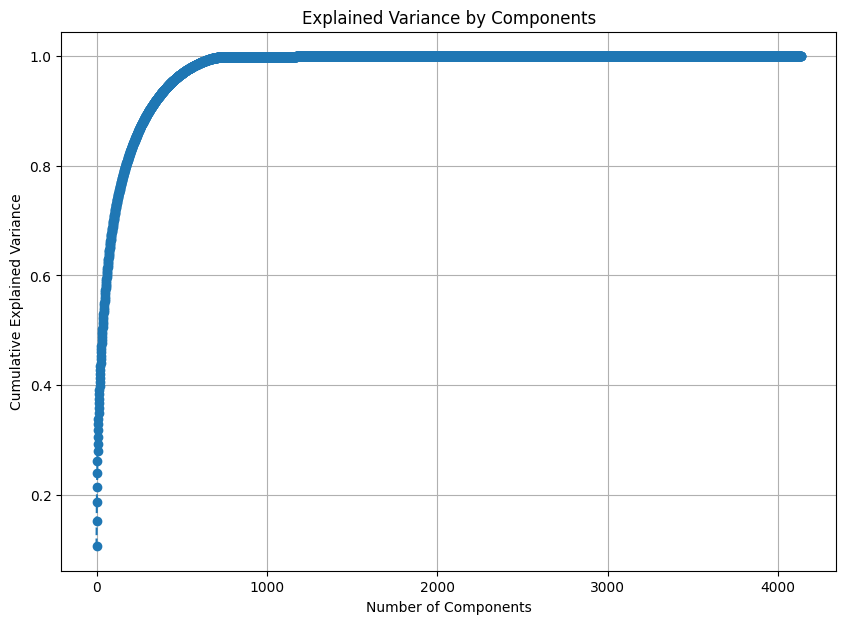

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Create PCA object without limiting n_components
pca = PCA()
pca.fit(encoded_df)

# Plotting
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()



In [31]:
pca_95 = PCA(n_components=0.95)
principalComponents_95 = pca_95.fit_transform(encoded_df)
print(f"Number of components to retain 95% variance: {pca_95.n_components_}")

In [23]:
encoded_df = pd.read_csv("C:\\Users\Gilbert\Documents\BCB_Research\Kcat_Benchmark_ML_Models\Data\encoded_amino.csv")

In [24]:
from sklearn.decomposition import PCA

# Assuming encoded_df is your one-hot encoded data from before
pca = PCA(n_components=433)
principal_components = pca.fit_transform(encoded_df)

# Convert to DataFrame for convenience
pca_df = pd.DataFrame(data=principal_components)


In [93]:
# lets add the SELFIES encoding into the result_df
import selfies as sf

# Define a function to convert SMILES to SELFIES
def smiles_to_selfies(smiles_string):
    try:
        return sf.encoder(smiles_string)
    except Exception as e:
        print(f"Error encoding {smiles_string}: {e}")
        return None

# Apply the function to the "Compound" column
data["Selfies"] = data["Compound"].apply(smiles_to_selfies)

data["Selfies"] = data["Selfies"].str.replace('.', '[.]')

In [94]:
data.head()

,EC_number,Species,Compound,Compound_name,Amino_encoding,Kcat,unit,smiles,Selfies
0,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDFLEKYYKFGSRHSAESQILKHLLKNLF...,-1.387216,s^(-1),<rdkit.Chem.rdchem.Mol object at 0x0000023643E...,[C][=C][C][=Branch1][=Branch1][=C][N][=C][Ring...
1,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,0.008600,s^(-1),<rdkit.Chem.rdchem.Mol object at 0x00000234A53...,[C][=C][C][=Branch1][=Branch1][=C][N][=C][Ring...
2,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,-1.080922,s^(-1),<rdkit.Chem.rdchem.Mol object at 0x00000234A53...,[C][=C][C][=Branch1][=Branch1][=C][N][=C][Ring...
3,1,39,C(CS)C(C(=O)O)N,L-Homocysteine,MGLEKKSALLEDLIEKCGGCAVVDGGFATQLEIHGAAINDPLWSAV...,-1.425969,s^(-1),<rdkit.Chem.rdchem.Mol object at 0x00000234A53...,[C][Branch1][Ring1][C][S][C][Branch1][=Branch1...
4,1,81,C(CS)C(C(=O)O)N,L-Homocysteine,MSQNNPLRALLDKQDILLLDGAMATELEARGCNLADSLWSAKVLVE...,-0.420216,s^(-1),<rdkit.Chem.rdchem.Mol object at 0x00000234A53...,[C][Branch1][Ring1][C][S][C][Branch1][=Branch1...


In [96]:
# let's encode the selfies string into one hot encoding.

# Extract all unique symbols from the SELFIES
def extract_symbols(selfies_string):
    return sf.split_selfies(selfies_string)

all_symbols = sorted(set(symbol for selfies in data["Selfies"] for symbol in extract_symbols(selfies)))

# One-Hot Encoding of the SELFIES strings
def one_hot_selfies(selfies_string):
    symbols = extract_symbols(selfies_string)
    return [1 if symbol in symbols else 0 for symbol in all_symbols]

# Creating a new DataFrame for one-hot encoded SELFIES
one_hot_df = pd.DataFrame(data["Selfies"].apply(one_hot_selfies).tolist(), columns=all_symbols)



In [114]:
# Assuming encoded_df is your one-hot encoded data from before
pca = PCA(n_components=5)
principal_components = pca.fit_transform(one_hot_df)

# Convert to DataFrame for convenience
one_hot_df = pd.DataFrame(data=principal_components)

In [144]:
# Assuming Data is your original dataframe
result_df = pd.concat([data['EC_number']], axis=1)

In [145]:
result_df.head()

,EC_number
0,0
1,0
2,0
3,1
4,1


In [146]:
result_df.columns = result_df.columns.astype(str)

In [147]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Assuming data['Kcat'] is your target column
X = result_df
y = data['Kcat']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create SVR model
svr = SVR()

# Train model
svr.fit(X_train_scaled, y_train)

# Predict Kcat values
y_pred = svr.predict(X_test_scaled)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 2.471379879428115


In [148]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Absolute Error: 1.2526982556824084
R-squared: 0.07061426136696891


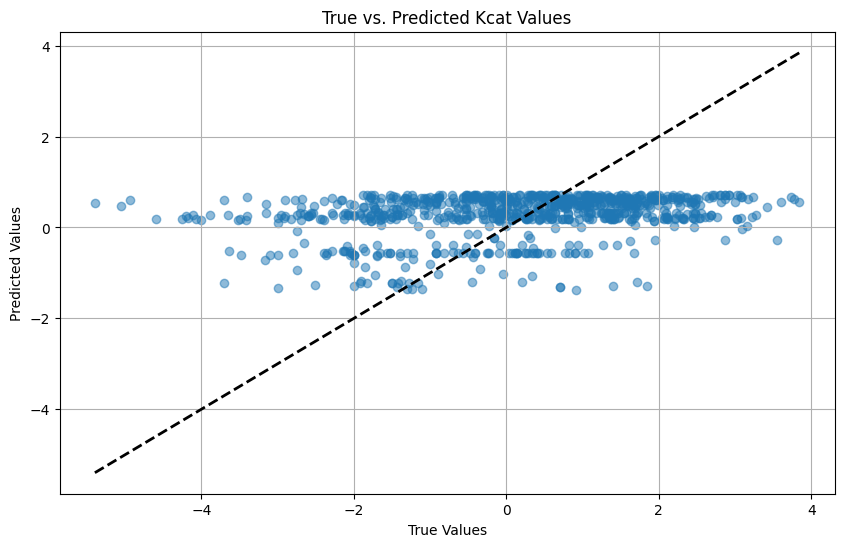

In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Kcat Values')
plt.grid(True)
plt.show()

In [128]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

# Create SVR model. You can adjust parameters as needed.
svr_model = SVR(kernel='linear', C=300, gamma='auto', epsilon=0.1)

# Choose number of folds; common choices are 5 or 10
n_folds = 5

# Cross validate
scores = cross_val_score(svr_model, X, y, cv=n_folds, scoring='neg_mean_absolute_error')

mae_scores = -scores

print(f"Mean MAE: {mae_scores.mean():.4f}")
print(f"Standard Deviation of MAE: {mae_scores.std():.4f}")

Mean MAE: 1.2678
Standard Deviation of MAE: 0.1158


In [132]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=1000, n_features=20, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = SVR()

param_grid = {
    'C': [300, 400, 500],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['auto', 'scale'],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [100, 200, 300], 'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='neg_mean_squared_error', verbose=3)

In [133]:
print(grid_search.best_params_)


{'C': 300, 'gamma': 'auto', 'kernel': 'linear'}


In [137]:
best_svr = grid_search.best_estimator_
predictions = best_svr.predict(X_test)

c:\Users\Gilbert\anaconda3\envs\bcb\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


ValueError: X has 438 features, but SVR is expecting 20 features as input.